## A/B Test Results Analysis


### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Reading an `ab_data.csv` data and storing it in `df`.

In [2]:
# Reading a dataset
df = pd.read_csv('data/ab_data.csv')

print(df.shape)
df.head(3)

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


The number of unique users.

In [3]:
df.nunique()['user_id']

290584

The proportion of users converted.

In [4]:
df.query('converted == 1').user_id.nunique() / df.nunique()['user_id']

0.12104245244060237

The number of times the `new_page` and `treatment` don't line up.

In [5]:
wrong_treatment = df.query('group == "treatment" & landing_page == "old_page"').count()['user_id']
wrong_control = df.query('group == "control" & landing_page == "new_page"').count()['user_id']
wrong_treatment + wrong_control

3893

Missing values

In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [7]:
treatment = df.loc[(df['group'] == "treatment") & (df['landing_page'] == "new_page")]
control = df.loc[(df['group'] == "control") & (df['landing_page'] == "old_page")]
df2 = treatment.append(control)

In [8]:
# Checking if all of the correct rows were removed - the result should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The number of unique users.

In [9]:
df2.nunique()['user_id']

290584

Repeated **user_id**.

In [10]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
# Dropping a duplicate
df2.drop(index=2893, inplace=True)

Probability of an individual converting regardless of the page they receive

In [12]:
converted = df2.query('converted == 1').count()['user_id'] 
total_users = df2.user_id.count()
converted / total_users

0.11959708724499628

Probability of an individual converting given the `control` group.

In [13]:
control_and_converted = df2.query('group == "control" & converted == 1').count()['user_id']
control = df2.query('group == "control"').count()['user_id']
p_conv_control = control_and_converted / control
p_conv_control

0.1203863045004612

Probability of an individual converting given the `treatment` group.

In [14]:
treatment_and_converted = df2.query('group == "treatment" & converted == 1').count()['user_id']
treatment = df2.query('group == "treatment"').count()['user_id']
p_conv_treat = treatment_and_converted / treatment
p_conv_treat

0.11880806551510564

Probability that an individual received the new page.

In [15]:
new_page = df2.query('landing_page == "new_page"').count()['user_id']
new_page / total_users

0.5000619442226688

Our analysis has shown that there is a 50% chance of receiving a new page, or, in other words, our `control` group is approximately equal to the `treatment` group. Points `b.` and `c.` have revealed that both groups have roughly equal Conversion rates, namely 12%. Given that, there is no sufficient evidence that the new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Assuming that the `old page` is better unless the `new page` proves to be definitely better at a Type I error rate of 5%(alpa), our hypotheses should be the following: <br>

$$H_0: p_{new} - p_{old} \leq 0$$ 


$$H_1: p_{new} - p_{old} > 0$$


**$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages.**


Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's also assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

**convert rate** for $p_{new}$ under the null.

In [16]:
p_new = df.query('converted == 1').user_id.count() / df.count()['user_id']
p_new

0.11965919355605512

**convert rate** for $p_{old}$ under the null.

In [17]:
p_old = df.query('converted == 1').user_id.count() / df.count()['user_id']
p_old

0.11965919355605512

$n_{new}$

In [18]:
treatment = df.loc[(df['group'] == "treatment") & (df['landing_page'] == "new_page")]
n_new = treatment.query('landing_page == "new_page"').nunique()['user_id']
n_new

145310

$n_{old}$

In [19]:
control = df.loc[(df['group'] == "control") & (df['landing_page'] == "old_page")]
n_old = control.query('landing_page == "old_page"').nunique()['user_id']
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [20]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), p_new])
prob_new = new_page_converted.mean()
prob_new

0.11960635881907646

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [21]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), p_old])
prob_old = old_page_converted.mean()
prob_old

0.12003524374630009

Finding $p_{new}$ - $p_{old}$ for the above simulated values.

In [22]:
prob_new - prob_old

-0.0004288849272236356

Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process and storing all 10,000 values in a numpy array called **p_diffs**.

In [23]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), p_new])
    prob_new = new_page_converted.mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), p_old])
    prob_old = old_page_converted.mean()
    p_diffs.append(prob_new - prob_old)

Plotting a histogram of the **p_diffs**.

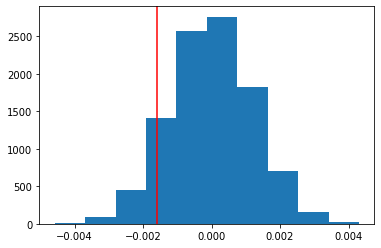

In [24]:
plt.hist(p_diffs);
plt.axvline(x=(p_conv_treat - p_conv_control), color = 'red');

Calculating the proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv** 

In [25]:
actual_diff = p_conv_treat - p_conv_control

(p_diffs > actual_diff).mean()

0.906

The ab ove proportion shows the percentage of simulated differences between $p_{new}$ and $p_{old}$ greater than the observed statistic. In scientific studies this value is called p-value. P-value represents the probabiliy of observing our statistic given the null hypothesis is true. Our p-value is approximately 90%, therefore, we don't have evidence to reject our null hypothesis. That is to say, we don't have evidence that the new page brings more conversions.

We also could also use a built-in to achieve similar results.

In [26]:
import statsmodels.api as sm

convert_old = control.query('converted == 1').count()['user_id']
convert_new = treatment.query('converted == 1').count()['user_id']
n_old = control.count()['user_id']
n_new = treatment.count()['user_id']

In [27]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145311)

Let's use `stats.proportions_ztest` to compute a test statistic and p-value.

In [28]:
from statsmodels.stats.proportion import proportions_ztest

In [29]:
z_score, pval = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

In [30]:
print('z_score =','{0:0.3f}'.format(z_score))
print('p-value =','{0:0.3f}'.format(pval))

z_score = 1.312
p-value = 0.905


We have performed a one-tailed Z-test determining if the new_page brings more conversion than the old one. The p-value of **0.905** means that we fail to reject the null hypothesis. These results agree with findings from the simulated proportions.

<a id='regression'></a>
### Part III - A regression approach

In this part, we will see that the results acheived in the previous A/B test can also be acheived by performing regression.<br>
Due to the nature of our independent variable we should apply **Logistic Regression**.

Our goal is to use **statsmodels** to fit the regression model you specified in  **Part I** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.

In [31]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']

df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1


In [32]:
lr = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [33]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:08:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

P-value associated with ab_page equals to 0.19. It differs since the Null hypothesis within Logistic Regression is $p_{old} = p_{new}$ and Alternative is $p_{old} \neq p_{new}$. Therefore, the p-value is a result of two-tail test. We can compare this value to the one derived from the null and alternative hypotheses of the Part II: $(1 - (0.19 / 2)) = 0.905$ $- $ right-tailed test.

### Additional Part

After testing if the conversion rate changes for different pages, let's study an effect based on which country a user lives.

In [34]:
countries_df = pd.read_csv('data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1


In [35]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [36]:
### Creating dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


After looking at the individual factors of country and page on conversion, let's now examine an interaction between page and country to see if there significant effects on conversion. 

In [37]:
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']

In [38]:
### Fitting Our Linear Model And Obtaining the Results
lr = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'UK', 'US', 'ab_UK', 'ab_US']])
result = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:08:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Our R-squared has increased, meaning that the addition of new variables has led to a better model fit. <br>
P-values of all of the model's independent variables appeared to be greater than 0.05(our alpha) meaning that they have no effect on user conversion. Given that independent variables have no correlation to our response variable, there is no much sense in their coefficients interpretation. <br>

Taking into account the results of all three parts of the A/B test result analysis, it will be reasonable not to switch to the new page as it doesn't bring better conversion.